# Projekt - Test t studenta

- Marcin Kostrzewski
- Krystian Wasilewski
- Mateusz Tylka

## Test t studenta

Metoda statystyczna służącą do porównania dwóch średnich między sobą gdy znamy liczbę badanych próbek, średnią arytmetyczną oraz wartość odchylenia standardowego lub wariancji.
Jest to jeden z mniej skomplikowanych i bardzo często wykorzystywanych testów statystycznych używanych do weryfikacji hipotez. Dzięki niemu możemy dowiedzieć się czy dwie różne średnie są różne niechcący (w wyniku przypadku) czy są różne istotnie statystycznie (np. z uwagi na naszą manipulację eksperymentalna).
Wyróżniamy 3 wersję testu t:

1. test t Studenta dla jednej próby
2. test t Studenta dla prób niezależnych  
3. test t Studenta dla prób zależnych

## Test Shapiro Wilka

Wszystkie rodzaje testów są testami parametrycznymi, a co za tym idzie nasze mierzone zmienne ilościowe powinny mieć rozkład normalny.  
Dzięki testowi Shapiro Wilka możemy sprawdzić to założenie.

## Testowanie hipotez metodą bootstrap

**Bootstrap** – metoda szacowania (estymacji) wyników poprzez wielokrotne losowanie ze zwracaniem z próby. Polega ona na utworzeniu nowego rozkładu wyników, na podstawie posiadanych danych, poprzez wielokrotne losowanie wartości z posiadanej próby. Metoda ze zwracaniem polega na tym, że po wylosowaniu danej wartości, “wraca” ona z powrotem do zbioru.

Metoda bootstrapowa znajduje zastosowanie w sytuacji, w której nie znamy rozkładu z populacji z której pochodzi próbka lub w przypadku rozkładów małych lub asymetrycznych. W takim wypadku, dzięki tej metodzie, wyniki testów parametrycznych i analiz opartych o modele liniowe są bardziej precyzyjne. Zazwyczaj losuje się wiele próbek, np. 2000 czy 5000.

# Definicje funkcji

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel, shapiro

In [41]:
dataset = pd.read_csv('experiment_data.csv') # TODO: del?

In [42]:
class Alternatives(Enum):
    LESS = 'less'
    GREATER = 'greater'

In [43]:
def calculate_t_difference(t_stat_sample, t_stat_list, alternative):
    """
    Funkcja oblicza procent statystyk testowych powstałych z prób bootstrapowych, 
    które róznią się od statystyki testowej powstałej ze zbioru według hipotezy alternatywnej.
    """
    all_stats = len(t_stat_list)
    stats_different_count = 0
    for t_stat_boot in t_stat_list:
        if alternative is Alternatives.LESS and t_stat_boot > t_stat_sample:
            stats_different_count += 1 
        elif alternative is Alternatives.GREATER and t_stat_boot < t_stat_sample:
            stats_different_count += 1
    return stats_different_count / all_stats

In [44]:
def t_test_1_samp(sample_1, population_mean=None, alternative=Alternatives.LESS):
    """
    Funkcja przeprowadza test T-studenta dla jednej zmiennej.
    """
    t_stat_from_sample, _ = ttest_1samp(a=sample_1, popmean=population_mean, alternative=alternative.value)
    t_stat_list = get_t_stats(sample_1, t_stat_fn=ttest_1samp, alternative=alternative, population_mean=population_mean)

    p = calculate_t_difference(t_stat_from_sample, t_stat_list, alternative)

    return p, t_stat_from_sample, t_stat_list

In [45]:
def t_test_ind(sample_1, sample_2, alternative=Alternatives.LESS):
    """
    Funkcja przeprowadza test T-studenta dla dwóch zmiennych niezależnych.
    """
    t_stat_from_sample, _ = ttest_ind(sample_1, sample_2, alternative=alternative.value)
    t_stat_list = get_t_stats(sample_1, sample_2, alternative=alternative, t_stat_fn=ttest_ind)

    p = calculate_t_difference(t_stat_from_sample, t_stat_list, alternative)

    return p, t_stat_from_sample, t_stat_list

In [46]:
def t_test_dep(sample_1, sample_2, alternative=Alternatives.LESS):
    """
    Funkcja przeprowadza test T-studenta dla dwóch zmiennych zależnych.
    """
    t_stat_list = get_t_stats(sample_1, sample_2, alternative=alternative, t_stat_fn=ttest_rel)
    t_stat_from_sample, _ = ttest_rel(sample_1, sample_2, alternative=alternative.value)

    p = calculate_t_difference(t_stat_from_sample, t_stat_list, alternative)

    return p, t_stat_from_sample, t_stat_list

In [47]:
def get_t_stats(sample_1, sample_2=None, t_stat_fn=ttest_1samp, alternative=Alternatives.LESS, population_mean=None):
    """Funkcja oblicza listę statystyk testowych dla każdej próbki bootstrapowej wybranej na podstawie danych sample_1 i sample_2"""
    t_stat_list = []

    # One sample test
    if t_stat_fn is ttest_1samp and sample_2 is None:
        if not population_mean:
            raise Exception("population_mean not provided")
        for bootstrap in generate_bootstraps(sample_1):
            stat, _ = t_stat_fn(bootstrap, population_mean, alternative=alternative.value)
            t_stat_list.append(stat)
        return t_stat_list

    # Two sample test
    for bootstrap_sample in generate_bootstraps(pd.concat((sample_1, sample_2), ignore_index=True)):
        bootstrap_1 = bootstrap_sample.iloc[: len(bootstrap_sample) // 2]
        bootstrap_2 = bootstrap_sample.iloc[len(bootstrap_sample) // 2 :]
        stat, _ = t_stat_fn(bootstrap_1, bootstrap_2, alternative=alternative.value)
        t_stat_list.append(stat)
    return t_stat_list

In [48]:
def pretty_print_test(p, t_stat_from_sample, t_stat_list, thesis, alternative, max_print=5):
    print('Wyniki bootstrapowej wersji testu T-studenta')
    print()
    print(f'Hipoteza: {thesis}')
    if alternative is Alternatives.LESS:
        print(f'Hipoteza alternatywna: średnia jest mniejsza')
    else:
        print(f'Hipoteza alternatywna: średnia jest większa')
    print()
    print(f'p: {p}')
    print(f'Wartość statystyki testowej z próby: {t_stat_from_sample}')
    print(f'Wartości statystyk z prób boostrapowych:')

    t_stat_list_len = len(t_stat_list)
    for i in range(min(max_print, t_stat_list_len)):
        print(f'{t_stat_list[i]}, ', end='')
    if max_print < t_stat_list_len:
        remaining = t_stat_list_len - max_print
        print(f'... (i {remaining} pozostałych)')

    print()
    print()

In [49]:
def generate_bootstraps(data, n_bootstraps=1000):
    data_size = data.shape[0]
    for _ in range(n_bootstraps):
        indices =  np.random.choice(len(data), size=data_size)
        yield data.iloc[indices, :]

In [50]:
def bootstrap_one_sample(sample, population_mean, alternative=Alternatives.LESS):
    p, t, ts = t_test_1_samp(
        sample_1=sample,
        population_mean=population_mean,
        alternative=alternative,
    )
    
    pretty_print_test(p, t, ts, f'średnia jest równa {population_mean}', alternative)
    print()
    return p, t, ts

In [51]:
def bootstrap_independent(sample_1, sample_2, alternative=Alternatives.LESS):
    p, t, ts = t_test_ind(
        sample_1=sample_1,
        sample_2=sample_2,
        alternative=alternative,
    )
    
    pretty_print_test(p, t, ts, 'średnie są takie same', alternative)
    return p, t, ts

In [52]:
def bootstrap_dependent(sample_1, sample_2, alternative=Alternatives.LESS):
    p, t, ts = t_test_dep(
        sample_1=sample_1,
        sample_2=sample_2,
        alternative=alternative,
    )
    
    pretty_print_test(p, t, ts, 'średnie są takie same', alternative)
    return p, t, ts

In [53]:
def draw_distribution(stats, comparision_value):
    """
    Funkcja rysuje rozkład statystyki testowej
    @param stats: lista statystyk testowych
    @param comparision_value: pierwotna próbka
    """
    plt.hist(stats)
    plt.axvline(comparision_value, color='red')
    plt.xlabel('Test statistic value')
    plt.ylabel('Frequency')
    plt.show()

# Wczytanie danych

In [54]:
dataset = pd.read_csv('experiment_data.csv')
heights_female = pd.DataFrame(dataset['Female height'].to_numpy())  # xd
heights_male = pd.DataFrame(dataset['Male height'].to_numpy())
weights_before = pd.DataFrame(dataset['Weight before'].to_numpy())
weights_after = pd.DataFrame(dataset['Weight after'].to_numpy())
print(np.mean(heights_female))
print(np.mean(heights_male))
print(np.mean(weights_before))
print(np.mean(weights_after))


0    169.5557
dtype: float64
0    175.1417
dtype: float64
0    79.6342
dtype: float64
0    76.5602
dtype: float64


# Jedna próba

**Test t Studenta dla jednej próby** wykorzystujemy gdy chcemy porównać średnią “teoretyczną” ze średnią, którą faktycznie możemy zaobserwować w naszej bazie danych. Średnia teoretyczna to średnia pochodząca z innych badań lub po prostu bez większych uzasadnień pochodząca z naszej głowy.

Wyobraźmy sobie, że mamy dane z takimi zmiennymi jak wzrost pewnej grupy ludzi. Dzięki testowi t Studenta dla jednej próby możemy dowiedzieć się np. czy wzrost naszego młodszego brata wynoszący 160cm odbiega znacząco od średniej wzrostu tej grupy.

### Hipoteza

*H0: Badana próba została wylosowana z populacji, w której wzrost osób wynosi średnio 160cm.*  
*H1: Badana próba została wylosowana z populacji gdzie średni wzrost jest większy 160cm.*

### Sprawdzenie założeń


In [55]:
# Sprawdzamy, czy próby mają rozkład normalny
shapiro_test = shapiro(heights_female)
print(f"p = {round(shapiro_test.pvalue,4)}")

p = 0.791


P wartość jest większa niż alfa = 0.05, więc próba ma prawdopodobnie rozkład normalny. Możemy stostować testy.

## Test


Wyniki bootstrapowej wersji testu T-studenta

Hipoteza: średnia jest równa 160.0
Hipoteza alternatywna: średnia jest większa

p: 0.5
Wartość statystyki testowej z próby: [19.1207964]
Wartości statystyk z prób boostrapowych:
[17.41702865], [19.17874674], [20.59090525], [17.666445], [19.3593138], ... (i 95 pozostałych)





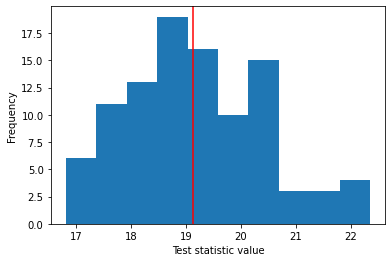

In [56]:
tested_mean = 160.0

p, t, ts = bootstrap_one_sample(heights_female, tested_mean, alternative=Alternatives.GREATER)
draw_distribution([x[0] for x in ts], t)

## Wniosek

Nie mamy podstaw, żeby odrzucić hipotezę zerową mówiącą, że średnia wynosi 160.

# Dwie próby niezależne

**Test t Studenta dla prób niezależnych** jest najczęściej stosowaną metodą statystyczną w celu porównania średnich z dwóch niezależnych od siebie grup. Wykorzystujemy go gdy chcemy porównać dwie grupy pod względem jakiejś zmiennej ilościowej. Na przykład gdy chcemy porównać średni wzrost kobiet i mężczyzn w danej grupie.
Zazwyczaj dwie średnie z różnych od siebie grup będą się różnić. Test t Studenta powie nam jednak czy owe różnice są istotne statystycznie – czy nie są przypadkowe.
Jeśli wynik testu t Studenta będzie istotny na poziomie p < 0,05 możemy odrzucić hipotezę zerową na rzecz hipotezy alternatywnej.

## Hipoteza

*H0: Średni wzrost w grupie mężczyzn jest taki sam jak średni w grupie kobiet. Hipoteza alternatywna z kolei*  
*H1: Kobiety będą niższe od mężczyzn pod względem wzrostu.*

## Sprawdzenie założeń

Założenie o rozkładzie normalnym danych - sprawdzane testem Shapiro-Wilka

In [57]:
shapiro_test = shapiro(heights_female)
print(f"p = {round(shapiro_test.pvalue,4)}")

shapiro_test = shapiro(heights_male)
print(f"p = {round(shapiro_test.pvalue,4)}")

p = 0.791
p = 0.7535


Wartości **p** w teście Shapiro-Wilka powyżej **0.05** -> Dane prawdopodobnie mają rozkład normalny

## Test

Wyniki bootstrapowej wersji testu T-studenta

Hipoteza: średnie są takie same
Hipoteza alternatywna: średnia jest mniejsza

p: 0.0
Wartość statystyki testowej z próby: [8.04931557]
Wartości statystyk z prób boostrapowych:
[0.2748409], [-0.61193473], [1.24335163], [-2.56879464], [0.34249038], ... (i 95 pozostałych)




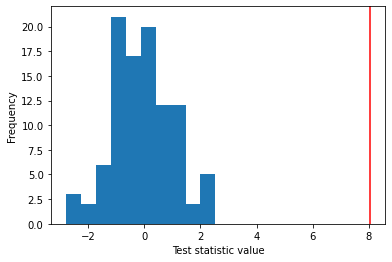

In [58]:
p, t, ts = bootstrap_independent(heights_male, heights_female)
ts = [x[0] for x in ts]
draw_distribution(ts, t)

## Wniosek

# Dwie próby zależne

W odróżnieniu od testu dla prób niezależnych, gdzie porównujemy dwie grupy, ten rodzaj testu stosujemy gdy poddajemy analizie tą samą pojedynczą grupę, ale dwukrotnie w czasie.

**Przykład**: Porównane zostały wagi przed dietą i po diecie.


### Hipoteza
H0 - Średnia waga nie uległa zmianie po zastosowaniu diety
H1 - Średnia waga po diecie jest znacząco mniejsza od wagi przed dietą



### Sprawdzenie założeń

Założenie o rozkładzie normalnym danych - sprawdzane testem Shapiro-Wilka

In [59]:
shapiro_test = shapiro(weights_before)
print(f"p = {round(shapiro_test.pvalue,4)}")

shapiro_test = shapiro(weights_after)
print(f"p = {round(shapiro_test.pvalue,4)}")

p = 0.3308
p = 0.4569


Wartości **p** w teście Shapiro-Wilka powyżej **0.05** -> Dane prawdopodobnie mają rozkład normalny

## Test

Wyniki bootstrapowej wersji testu T-studenta

Hipoteza: średnie są takie same
Hipoteza alternatywna: średnia jest mniejsza

p: 0.0
Wartość statystyki testowej z próby: [48.30834167]
Wartości statystyk z prób boostrapowych:
[-0.18332849], [-1.21537352], [1.64628473], [1.06552535], [-0.71420173], ... (i 95 pozostałych)




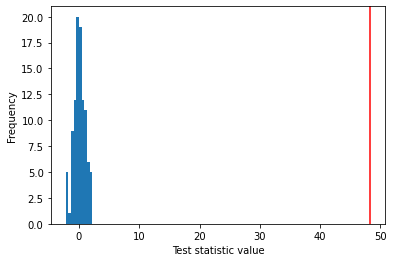

In [39]:
p, t, ts = bootstrap_dependent(weights_before, weights_after)
ts = [x[0] for x in ts]
draw_distribution(ts, t)

## Wniosek

???